## AoTu to DNs

In [1]:
# Import standard libraries
import os, datetime
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pl
import igraph
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bokeh
import hvplot.pandas
import holoviews as hv
from holoviews import opts
hv.extension('bokeh', 'matplotlib')
%matplotlib inline

import bokeh.palettes
from bokeh.plotting import figure, show, output_notebook
output_notebook()
import seaborn as sb
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz, load_npz
# import cairo
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import zscore
from scipy.sparse.linalg import norm
import networkx as nx
from pyvis.network import Network

## Load environment variables from .env file and find project root
import sys
from dotenv import load_dotenv, find_dotenv
load_dotenv()
PROJECT_ROOT = Path(find_dotenv()).parent
# data_path = Path(PROJECT_ROOT, 'results', 'eyemap')
store_path = Path(PROJECT_ROOT, 'results','AOTU_Connectivity')
sys.path.append(str(PROJECT_ROOT.joinpath('src')))


from utils import olc_client
c = olc_client.connect(verbose=True)

from utils.celltype_conn_by_roi import CelltypeConnByRoi
from utils.celltype_conn_plotter import CelltypeConnPlotter
from utils.plotter import plot_cns, save_figure, get_skeletons, get_skeleton, get_meshes, get_mesh, show_figure
from utils.helper import slugify
from utils.neuron_bag import NeuronBag

# Import neuPrint specific libraries
from neuprint import Client, fetch_neurons, NeuronCriteria as NC, fetch_neurons, fetch_simple_connections, fetch_adjacencies, connection_table_to_matrix, merge_neuron_properties, NotNull, fetch_synapse_connections, fetch_neurons,fetch_primary_rois, fetch_all_rois, fetch_synapses, fetch_roi_hierarchy
from neuprint.utils import connection_table_to_matrix



Loading BokehJS ...

Connected to https://neuprint-cns.janelia.org[male-cns:v0.9].
Client: neuprint-python v1.7.4
User: aishahamid201@gmail.com [readwrite]



In [2]:
# Fetch AOTU neurons and get their types
neurons_AOTU_df,roi_AOTU_df = fetch_neurons(NC(type='^AOTU.*'))
neurons_DN_df,roi_DN_df = fetch_neurons(NC(type='^DN.*'))
neurons_AOTU_df, neurons_DN_df

/Users/hamida/Documents/GitHub/male-drosophila-visual-system-connectome-code/.pixi/envs/default/lib/python3.12/site-packages/neuprint/client.py:609: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neuron_props_val = df_results.iloc[0][0]
/Users/hamida/Documents/GitHub/male-drosophila-visual-system-connectome-code/.pixi/envs/default/lib/python3.12/site-packages/neuprint/client.py:619: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neuron_props_val = df_results.iloc[0][0]


(        bodyId   instance     type   pre   post  downstream  upstream  \
 0        10005  AOTU019_R  AOTU019  2837  31981       23423     31981   
 1        10031  AOTU041_R  AOTU041  2134  20586       13446     20586   
 2        10070  AOTU019_L  AOTU019  2836  30714       23596     30714   
 3        10148  AOTU041_L  AOTU041  2336  19960       14187     19960   
 4        10212  AOTU042_L  AOTU042  3579  10679       22690     10679   
 ..         ...        ...      ...   ...    ...         ...       ...   
 307     555803  AOTU024_R  AOTU024   814   2240        6989      2240   
 308     557095  AOTU008_L  AOTU008   392   2167        3198      2167   
 309     565505  AOTU008_R  AOTU008   315   2727        2802      2727   
 310     902249  AOTU038_R  AOTU038   111    459         704       459   
 311  382559434  AOTU001_L  AOTU001   321   1829        2168      1829   
 
             size  status     statusLabel  ... assignedOlHex2 location  \
 0    11847745920  Traced  Roughly t

In [3]:
AOTU_celltypes = neurons_AOTU_df['type'].unique()
DN_celltypes = neurons_DN_df['type'].unique()
AOTU_celltypes, DN_celltypes

(array(['AOTU019', 'AOTU041', 'AOTU042', 'AOTU023', 'AOTU012', 'AOTU035',
        'AOTU005', 'AOTU100m', 'AOTU016_c', 'AOTU061', 'AOTU052',
        'AOTU103m', 'AOTU063_b', 'AOTU064', 'AOTU033', 'AOTU101m',
        'AOTU063_a', 'AOTU049', 'AOTU027', 'AOTU014', 'AOTU015', 'AOTU046',
        'AOTU050', 'AOTU024', 'AOTU059', 'AOTU009', 'AOTU008', 'AOTU045',
        'AOTU065', 'AOTU007_c', 'AOTU002_c', 'AOTU029', 'AOTU016_a',
        'AOTU002_a', 'AOTU026', 'AOTU020', 'AOTU017', 'AOTU028',
        'AOTU016_b', 'AOTU036', 'AOTU006', 'AOTU043', 'AOTU048', 'AOTU013',
        'AOTU051', 'AOTU034', 'AOTU011', 'AOTU002_b', 'AOTU022', 'AOTU062',
        'AOTU032', 'AOTU001', 'AOTU007_b', 'AOTU047', 'AOTU003',
        'AOTU007_a', 'AOTU054', 'AOTU053', 'AOTU030', 'AOTU056', 'AOTU055',
        'AOTU060', 'AOTU102m', 'AOTU038', 'AOTU058', 'AOTU037', 'AOTU018',
        'AOTU004', 'AOTU039', 'AOTU040', 'AOTU021', 'AOTU025'],
       dtype=object),
 array(['DNp01', 'DNp18', 'DNg56', 'DNg100', 'DNpe013',

In [4]:
#  Define pre- and post-synaptic cell types
celltypes_pre = AOTU_celltypes
celltypes_post = DN_celltypes

In [5]:
#  Set connection weight threshold
threshold = 5
# Fetch synaptic connectivity between these types
neu_df, conn_df = fetch_adjacencies(celltypes_pre, celltypes_post, min_roi_weight=threshold)
# Merge with neuron properties to get types on both sides
conn_AOTU_DN_df = merge_neuron_properties(neu_df, conn_df)

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# Group by type combinations and sum the weights
conn_AOTU_DN_df_type = conn_AOTU_DN_df.groupby(['type_pre','type_post'])['weight'].sum().reset_index()
conn_AOTU_DN_df_type

,type_pre,type_post,weight
0,AOTU001,DNa02,404
1,AOTU001,DNa03,25
2,AOTU001,DNa06,47
3,AOTU001,DNa11,6
4,AOTU001,DNa13,104
...,...,...,...
463,AOTU103m,DNp13,57
464,AOTU103m,DNp36,5
465,AOTU103m,DNp68,19
466,AOTU103m,DNpe034,130


In [7]:
# Pivot to create matrix form of the connection weights
matrix_df = conn_AOTU_DN_df_type.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)
# Normalize each column (post-synaptic type) by its total input
norm_matrix_df = matrix_df.div(matrix_df.sum(axis=0), axis=1)

In [8]:
#conn_AOTU_DN_df_type_sort = conn_AOTU_DN_df_type.sort_values(by='weight', ascending=True)
#filter for only strong connections
#conn_AOTU_DN_df_type_top = conn_AOTU_DN_df_type_sort[conn_AOTU_DN_df_type_sort['weight']>200]
#matrix_df = conn_AOTU_DN_df_type_top.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)

matrix_df = conn_AOTU_DN_df_type.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)
# Normalize each column (post-synaptic type) by its total input
norm_matrix_df = matrix_df.div(matrix_df.sum(axis=0), axis=1)


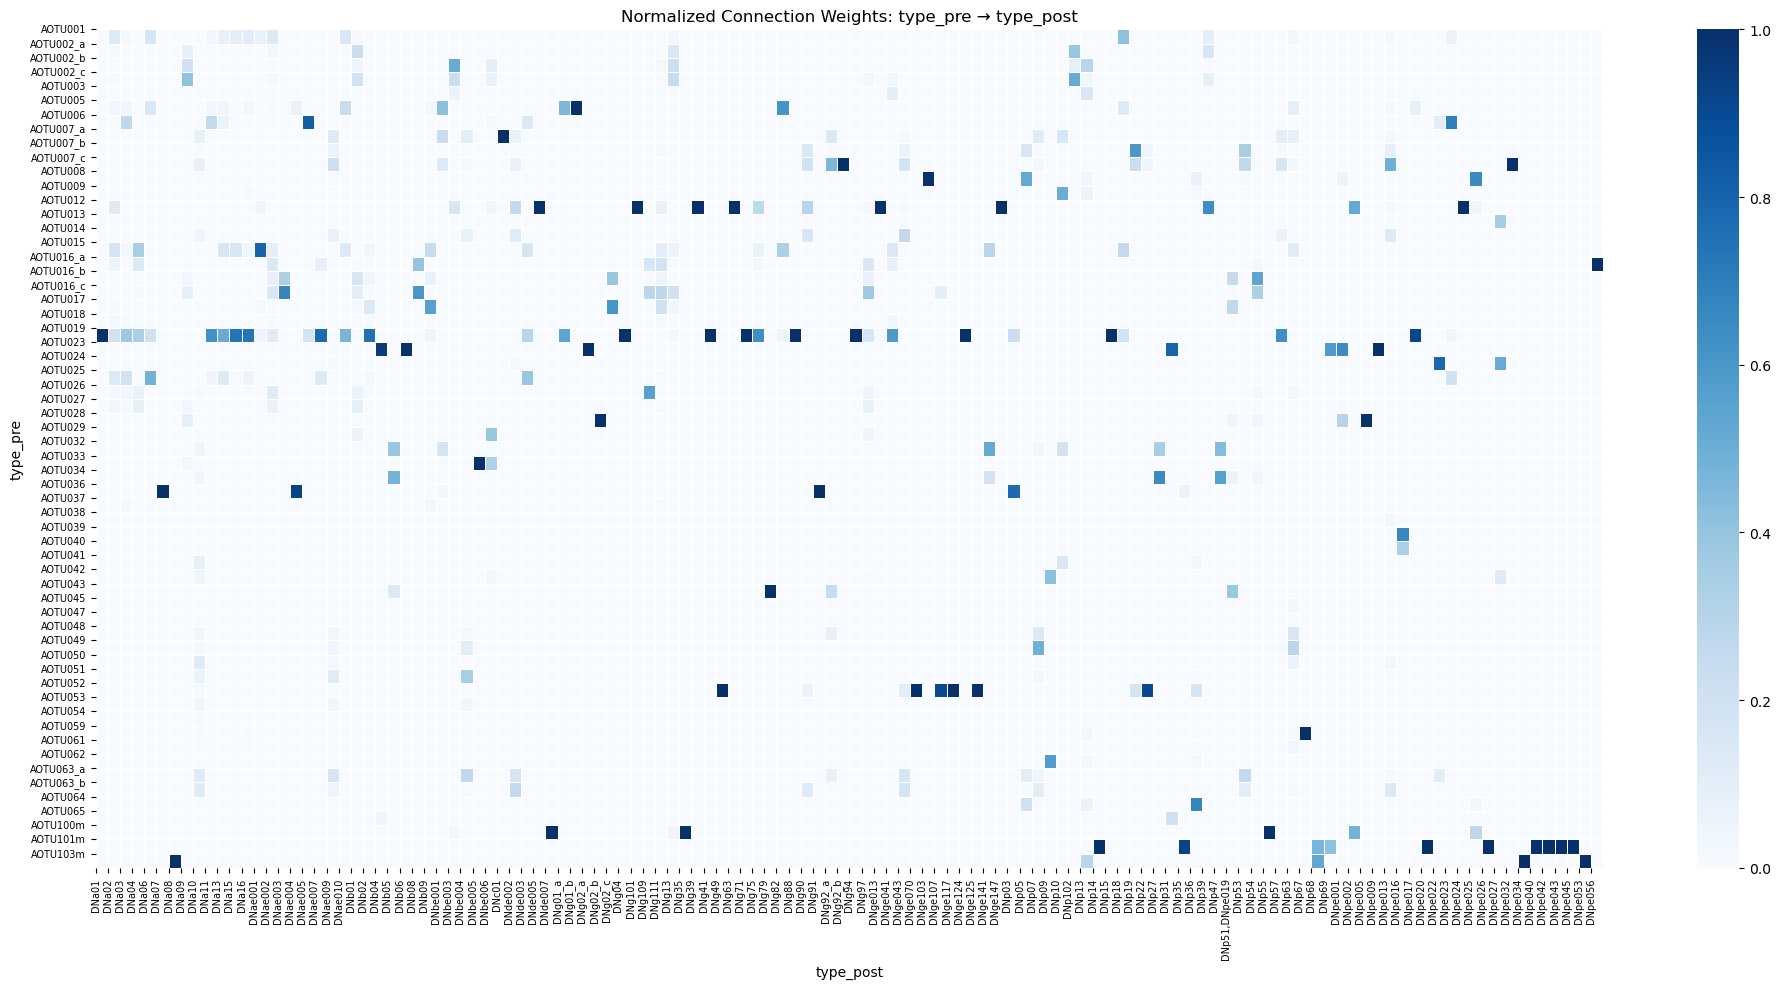

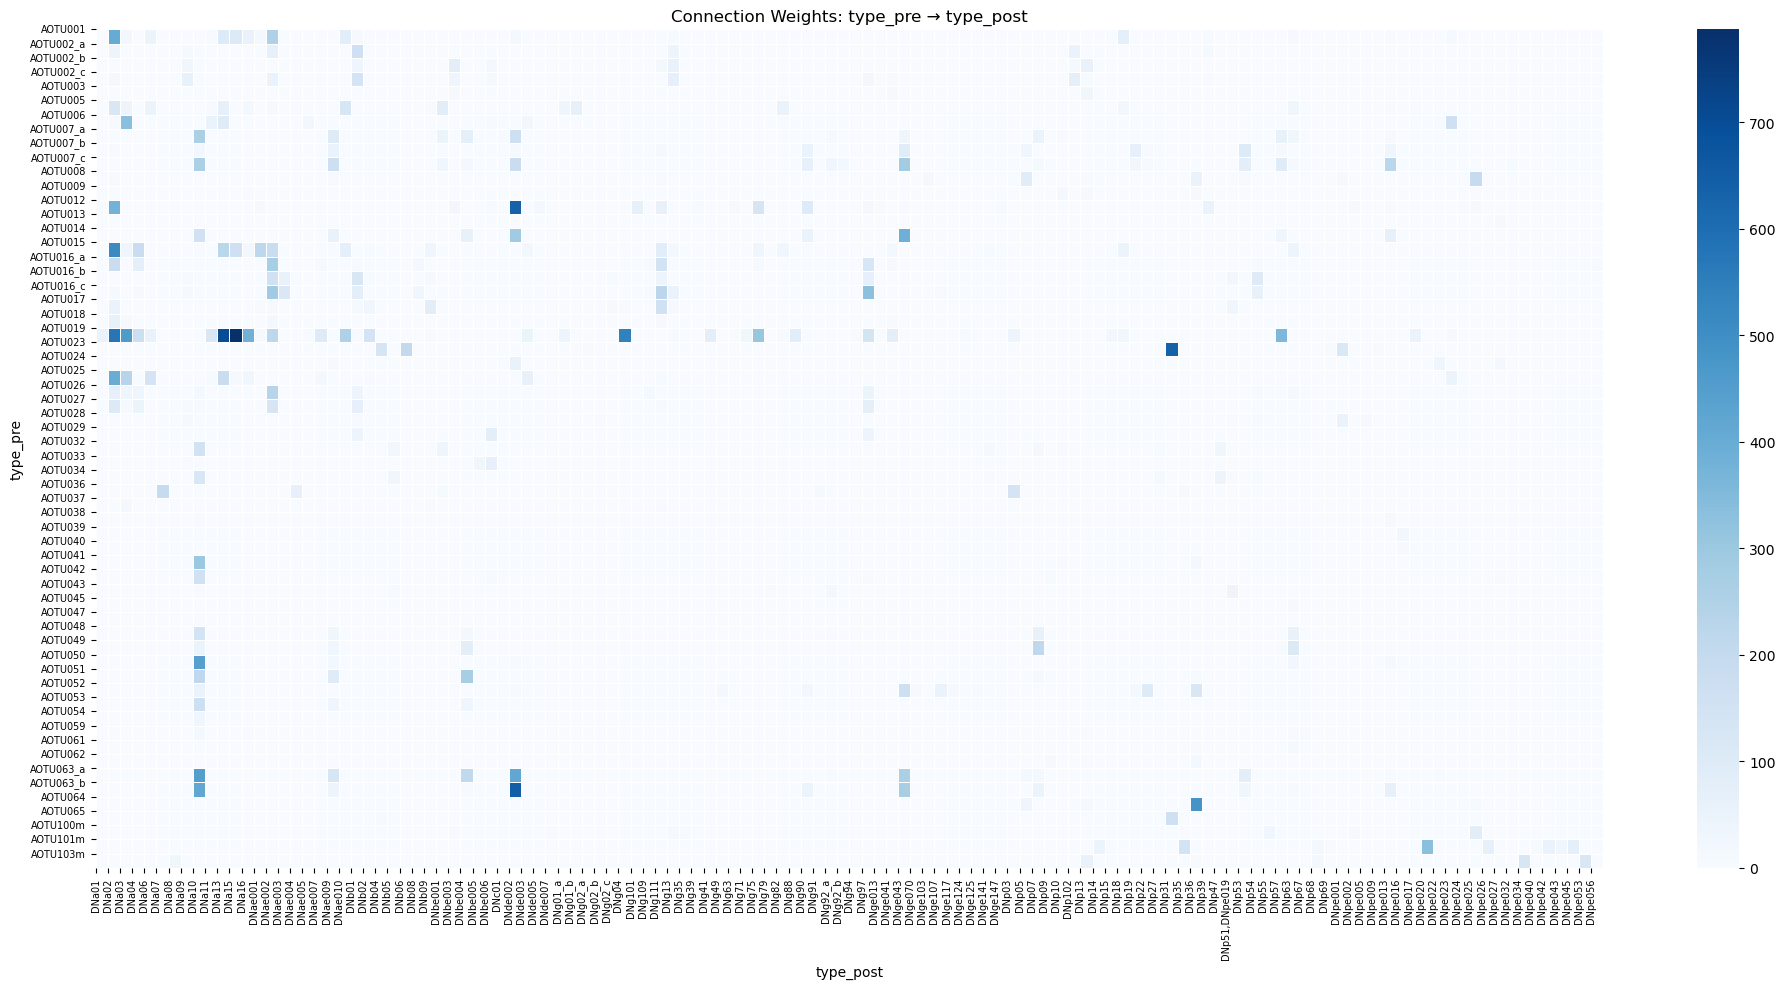

In [9]:
# Create the heatmap
plt.figure(figsize=(20, 10))
ax = sb.heatmap(norm_matrix_df, cmap='Blues', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Normalized Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(norm_matrix_df.index)))
ax.set_yticklabels(norm_matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(norm_matrix_df.columns)))
ax.set_xticklabels(norm_matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()


# Real weights without normalizing
# Create the heatmap
plt.figure(figsize=(20, 10))
ax = sb.heatmap(matrix_df, cmap='Blues', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(matrix_df.index)))
ax.set_yticklabels(matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(matrix_df.columns)))
ax.set_xticklabels(matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()